In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
# custom imports
import utils
import train
import mcts
from rtfm import featurizer as X
import os

Using device cuda:0
Using device cuda:0


In [2]:
# Check only if main logic of the training loop works
ucb_C = 1.0
discount = 0.9 # try with smaller discount
episode_length = 32
max_actions = 5
num_simulations = 100
device = mcts.device
n_episodes = 2000
memory_size = 528
batch_size = 32
n_steps = 5
tau = 0.5 # new_trg_params = (1-tau)*old_trg_params + tau*value_net_params
temperature = 1.

training_params = dict(
    ucb_C = 1.0,
    discount = 0.9,
    episode_length = 32,
    max_actions = 5,
    num_simulations = 100,
    device = mcts.device,
    n_episodes = 2000,
    memory_size = 528,
    batch_size = 32,
    n_steps = 5,
    tau = 0.5,
    temperature = 1.
)

In [3]:
flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)

In [4]:
training_dict = torch.load("save_dir/policy_AAD/training_dict_5000")
object_ids = training_dict["object_ids"]
pv_net = training_dict["pv_net"]
losses = training_dict["losses"]
entropies = training_dict["entropies"]
episodes_played = training_dict["episodes_played"]
training_params = training_dict["training_params"]
total_rewards = training_dict["total_rewards"]
n_steps = training_params["n_steps"]
accuracies = training_dict["accuracies"]

In [5]:
rb = torch.load("save_dir/policy_AAD/replay_buffer")

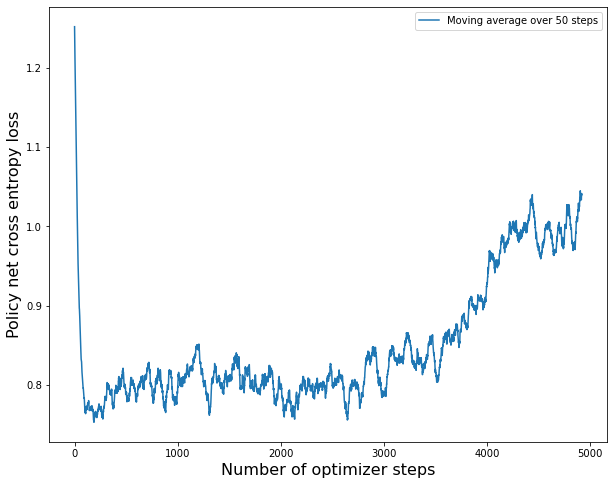

In [6]:
window = 50
utils.plot_losses(losses, window)

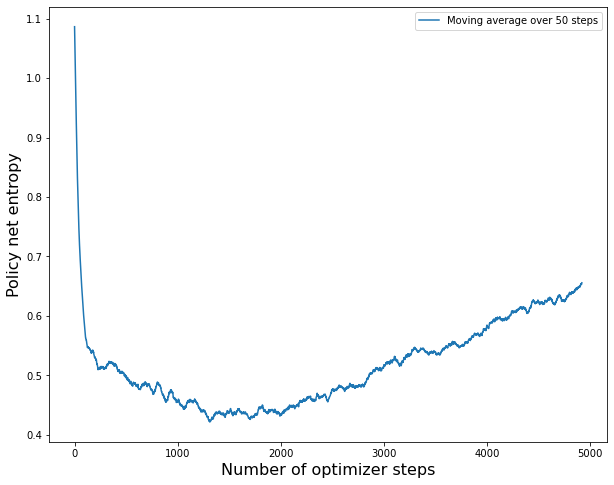

In [7]:
utils.plot_entropies(entropies, window)

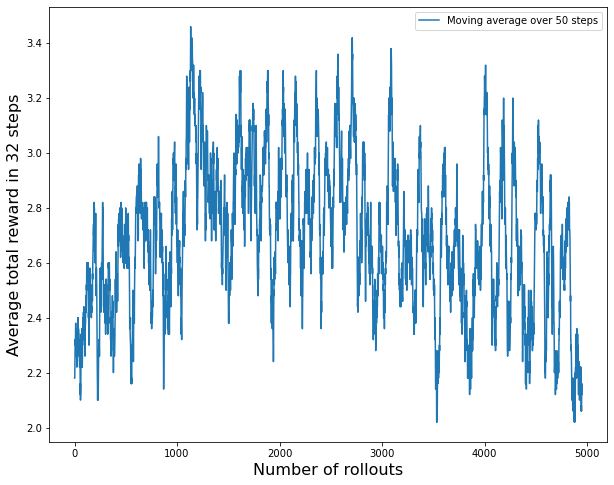

In [8]:
utils.plot_rewards(total_rewards, window)

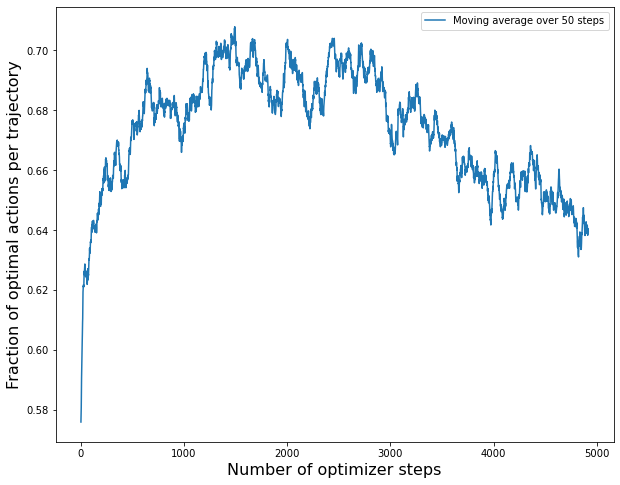

In [9]:
utils.plot_action_optimality(accuracies, window)

# Tests

1. Create relevant baselines with which we can confront the result. 
2. Evaluate the current network using as metrics the percentage of solved episodes and the percentage of optimal actions played (which gives a better measure of how efficient is an agent in solving an episode)


Baselines:
1. **Standard MCTS** has an average performance of **0.9** per episode (for a maximum of 1). 
2. The **optimal policy** instead has an average performance of **0.97**.
3. The same **policy network** architecture, **trained on trajectories from the optimal policy**, has a performance of **0.93**.
4. The **policy MCTS** with the policy from point 3 (with the same num simulations and max actions used in this training cycle) has a performance of **0.97**, i.e. an optimal performance.

In [10]:
ucb_C = training_params["ucb_C"]
discount = training_params["discount"]
episode_length = training_params["episode_length"]
max_actions = training_params["max_actions"]
num_simulations = training_params["num_simulations"]
device = mcts.device
n_episodes = training_params["n_episodes"]
memory_size = training_params["memory_size"]
batch_size = training_params["batch_size"]
n_steps = training_params["n_steps"]
tau = training_params["tau"]

In [11]:
test_episodes = 200
results = train.play_episode_policy_value_net_v1(
    pv_net,
    game_simulator,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    object_ids,
    mode="simulate",
    dir_noise=True,
    render = True,
    debug_render=False
)


██████
█ ?  █
█ @  █
█!y  █
█  n █
██████

Action  Stay : Q-value=0.000 - Visit counts=0
Action  Up : Q-value=0.000 - Visit counts=0
Action  Down : Q-value=0.875 - Visit counts=49
Action  Left : Q-value=-0.900 - Visit counts=1
Action  Right : Q-value=0.000 - Visit counts=0
Action selected from MCTS:  2 (Down)
Best actions:  [2] ['Down']

██████
█ ?  █
█    █
█!@  █
█  n █
██████
blessed sword
Reward received:  0
Done:  False
Action  Stay : Q-value=0.000 - Visit counts=0
Action  Up : Q-value=0.000 - Visit counts=0
Action  Down : Q-value=-0.282 - Visit counts=1
Action  Left : Q-value=1.000 - Visit counts=97
Action  Right : Q-value=0.000 - Visit counts=0
Action selected from MCTS:  3 (Left)
Best actions:  [3] ['Left']

██████
█ ?  █
█    █
█@   █
█  n █
██████
blessed sword
Reward received:  1
Done:  True


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [12]:
scores = []
accuracies = []
for i in range(test_episodes):
    if i == 0:
        render=True
    else:
        render=False
        
    print("Playing episode %d"%(i+1))
    results = train.play_episode_policy_value_net_v1(
                                                    pv_net,
                                                    game_simulator,
                                                    episode_length,
                                                    ucb_C,
                                                    discount,
                                                    max_actions,
                                                    num_simulations,
                                                    object_ids,
                                                    mode="simulate",
                                                    render = render,
                                                    debug_render=False
                                                    )
    total_reward, frame_lst, reward_lst, done_lst, action_is_optimal = results
    scores.append(total_reward)
    accuracies.append(np.array(action_is_optimal, dtype=np.float).mean())
print("Average score: %.2f"%np.mean(scores))
print("Average optimal action accuracy: %.2f"%np.mean(accuracies))

Playing episode 1

██████
█  y@█
█!   █
█ n  █
█   ?█
██████

Action  Stay : Q-value=0.000 - Visit counts=0
Action  Down : Q-value=-0.430 - Visit counts=1
Action  Left : Q-value=0.664 - Visit counts=49
Action selected from MCTS:  3 (Left)
Best actions:  [3] ['Left']

██████
█  @ █
█!   █
█ n  █
█   ?█
██████
blessed sword
Reward received:  0
Done:  False
Action  Stay : Q-value=0.000 - Visit counts=0
Action  Down : Q-value=0.000 - Visit counts=0
Action  Left : Q-value=0.782 - Visit counts=98
Action  Right : Q-value=0.000 - Visit counts=0
Action selected from MCTS:  3 (Left)
Best actions:  [3, 2] ['Left', 'Down']

██████
█ @  █
█!   █
█ n  █
█   ?█
██████
blessed sword
Reward received:  0
Done:  False
Action  Stay : Q-value=0.000 - Visit counts=0
Action  Down : Q-value=0.000 - Visit counts=0
Action  Left : Q-value=0.884 - Visit counts=146
Action  Right : Q-value=0.206 - Visit counts=1
Action selected from MCTS:  3 (Left)
Best actions:  [3, 2] ['Left', 'Down']

██████
█@   █
█!   █
█ n  █

Experiment ID: AAC <br>
Average score: 0.87 <br>
Average optimal action accuracy: 0.84

Experiment ID: AAD <br>
Average score: 0.79 <br>
Average optimal action accuracy: 0.81

Comment: training for longer while using the Dirichlet noise didn't improve the training and ater a certain point the policy collapsed, worsening.

### Now adding Dirichlet noise to the root

In [18]:
dir_scores = []
dir_accuracies = []
for i in range(test_episodes):
    if i == 0:
        render=True
    else:
        render=False
        
    print("Playing episode %d"%(i+1))
    results = train.play_episode_policy_value_net_v1(
                                                    pv_net,
                                                    game_simulator,
                                                    episode_length,
                                                    ucb_C,
                                                    discount,
                                                    max_actions,
                                                    num_simulations,
                                                    object_ids,
                                                    dir_noise=True,
                                                    mode="simulate",
                                                    render = render,
                                                    debug_render=False
                                                    )
    total_reward, frame_lst, reward_lst, done_lst, action_is_optimal = results
    dir_scores.append(total_reward)
    dir_accuracies.append(np.array(action_is_optimal, dtype=np.float).mean())
print("Average score: %.2f"%np.mean(dir_scores))
print("Average optimal action accuracy: %.2f"%np.mean(dir_accuracies))

Playing episode 1

██████
█y   █
█ @?n█
█!   █
█    █
██████

Action  Stay : Q-value=0.000 - Visit counts=0
Action  Up : Q-value=0.550 - Visit counts=48
Action  Down : Q-value=-0.531 - Visit counts=1
Action  Left : Q-value=0.000 - Visit counts=1
Action  Right : Q-value=0.000 - Visit counts=0
Action selected from MCTS:  1 (Up)
Best actions:  [1, 3] ['Up', 'Left']

██████
█y@  █
█  ?n█
█!   █
█    █
██████

Reward received:  0
Done:  False
Action  Stay : Q-value=-0.729 - Visit counts=1
Action  Down : Q-value=0.000 - Visit counts=0
Action  Left : Q-value=0.698 - Visit counts=96
Action  Right : Q-value=0.000 - Visit counts=0
Action selected from MCTS:  3 (Left)
Best actions:  [3] ['Left']

██████
█@   █
█  ?n█
█!   █
█    █
██████
blessed sword
Reward received:  0
Done:  False
Action  Stay : Q-value=0.798 - Visit counts=144
Action  Down : Q-value=-0.656 - Visit counts=1
Action  Right : Q-value=0.000 - Visit counts=0
Action selected from MCTS:  0 (Stay)
Best actions:  [2] ['Down']

██████
█

Average score: 0.88 <br>
Average optimal action accuracy: 0.83

Comment: for a given set of (trained) weights it seems that the addition of Dirichlet noise to the root's prior does not change significantly the performance of the algorithm. This is a good thing, because while it provides an exploration bonus at the root of the MCTS, it doesn't impair or bias too much the performance.